# Import packages

In [ ]:
from tqdm import tqdm
from collections import Counter
import lightgbm as lgb
import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
from xgboost import plot_importance
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.metrics import cohen_kappa_score, mean_squared_error, f1_score
from sklearn.model_selection import GroupKFold, KFold, StratifiedKFold
import json
import pandas as pd
import numpy as np
import warnings
import random
import time
import os
import matplotlib.pyplot as plt
import multiprocessing
from multiprocessing import Lock, Process, Queue, current_process
import scipy as sp
from functools import partial
from numba import jit
from sklearn.preprocessing import OneHotEncoder
import gc
pd.set_option('display.max_columns', 1000)
#warnings.filterwarnings('ignore')

In [2]:
DATA_PATH =""# "../input/liverpool-ion-switching"

train = pd.read_csv(os.path.join(DATA_PATH, 'train.csv'))
test = pd.read_csv(os.path.join(DATA_PATH, 'test.csv'))
submission_df = pd.read_csv(os.path.join(DATA_PATH, 'sample_submission.csv'))

# Feature Engineering

In [3]:
from tqdm import tqdm_notebook
for batch_size in tqdm_notebook([10000, 25000, 50000]):
    train['batch'] = ((train['time'] * 10000) - 1) // batch_size
    train['batch_index'] = ((train['time'] * 10000) - 1)  - (train['batch'] * batch_size) #10_000 is same as 10000.
    train['batch_slices'] = train['batch_index']  // (batch_size / 10)
    train['batch_slices2'] = train['batch'].astype(str).str.zfill(3) + '_' + train['batch_slices'].astype(str).str.zfill(3) #zfill() is zero patting function
    
    for agg_feature in ['batch', 'batch_slices2']:
        train[f"min_{agg_feature}_{batch_size}"] = train.groupby(agg_feature)['signal'].transform('min')
        train[f"max_{agg_feature}_{batch_size}"] = train.groupby(agg_feature)['signal'].transform('max')
        train[f"std_{agg_feature}_{batch_size}"] = train.groupby(agg_feature)['signal'].transform('std')
        train[f"mean_{agg_feature}_{batch_size}"] = train.groupby(agg_feature)['signal'].transform('mean')
        
        train[f"min_{agg_feature}_{batch_size}_diff"] = train[f"min_{agg_feature}_{batch_size}"] - train['signal']
        train[f"max_{agg_feature}_{batch_size}_diff"] = train[f"max_{agg_feature}_{batch_size}"] - train['signal']
        train[f"std_{agg_feature}_{batch_size}_diff"] = train[f"std_{agg_feature}_{batch_size}"] - train['signal']
        train[f"mean_{agg_feature}_{batch_size}_diff"] = train[f"mean_{agg_feature}_{batch_size}"] - train['signal']
        
        train[f'signal_shift+1_{agg_feature}_{batch_size}'] = train.groupby([agg_feature]).shift(1)['signal']
        train[f'signal_shift-1_{agg_feature}_{batch_size}'] = train.groupby([agg_feature]).shift(-1)['signal']
        train[f'signal_shift+2_{agg_feature}_{batch_size}'] = train.groupby([agg_feature]).shift(2)['signal']
        train[f'signal_shift-2_{agg_feature}_{batch_size}'] = train.groupby([agg_feature]).shift(-2)['signal']
        gc.collect()

    window_sizes = [ 1000, 5000, 10000]#100, 500,10, 25, 50, 25000, 30000]
    for window in window_sizes:
        train["rolling_maen_" + str(window) + '_batch_' + str(batch_size)] = train.groupby('batch')['signal'].rolling(window=window).mean().reset_index()['signal']
        train["rolling_std_" + str(window) + '_batch_' + str(batch_size)] = train.groupby('batch')['signal'].rolling(window=window).std().reset_index()['signal']
        #train["rolling_var_" + str(window) + '_batch_' + str(batch_size)] = train.groupby('batch')['signal'].rolling(window=window).var().reset_index()['signal']
        train["rolling_min_" + str(window) + '_batch_' + str(batch_size)] = train.groupby('batch')['signal'].rolling(window=window).min().reset_index()['signal']
        train["rolling_max_" + str(window) + '_batch_' + str(batch_size)] = train.groupby('batch')['signal'].rolling(window=window).max().reset_index()['signal']
        #train["rolling_median_" + str(window) + '_batch_' + str(batch_size)] = train.groupby('batch')['signal'].rolling(window=window).median().reset_index()['signal']
        #train["rolling_min_max_ratio_" + str(window)+ '_batch_' + str(batch_size)] = train["rolling_min_" + str(window)+ '_batch_' + str(batch_size)] / train["rolling_max_" + str(window)+ '_batch_' + str(batch_size)]
        #train["rolling_min_max_diff_" + str(window)+ '_batch_' + str(batch_size)] = train["rolling_max_" + str(window)+ '_batch_' + str(batch_size)] - train["rolling_min_" + str(window)+ '_batch_' + str(batch_size)]
        #train["rolling_min_max_mean_" + str(window)+ '_batch_' + str(batch_size)] = (train["rolling_max_" + str(window)+ '_batch_' + str(batch_size)] + train["rolling_min_" + str(window)+ '_batch_' + str(batch_size)])/2
        a = (train['signal'] - train['rolling_min_' + str(window)+ '_batch_' + str(batch_size)]) / (train['rolling_max_' + str(window)+ '_batch_' + str(batch_size)] - train['rolling_min_' + str(window)+ '_batch_' + str(batch_size)])
        train["norm_" + str(window)+ '_batch_' + str(batch_size)] = a * (np.floor(train['rolling_max_' + str(window)+ '_batch_' + str(batch_size)]) - np.ceil(train['rolling_min_' + str(window)+ '_batch_' + str(batch_size)]))
        del a
        gc.collect()

        ewma = pd.Series.ewm

        train[f'exp_Moving__{window}_{batch_size}'] = train.groupby('batch')['signal'].apply(lambda x: x.ewm(alpha=0.5, adjust=False).mean())
train.fillna(0, inplace=True)

In [4]:
train=train.drop(["batch_slices2"],axis=1) #drop categoricaldata
gc.collect()

4

In [5]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [6]:
train=reduce_mem_usage(train)

Mem. usage decreased to 1254.08 Mb (75.1% reduction)


In [7]:
from tqdm import tqdm_notebook
for batch_size in tqdm_notebook([10000, 25000, 50000]):
    test['batch'] = ((test['time'] * 10000) - 1) // batch_size
    test['batch_index'] = ((test['time'] * 10000) - 1)  - (test['batch'] * batch_size) #10_000 is same as 10000.
    test['batch_slices'] = test['batch_index']  // (batch_size / 10)
    test['batch_slices2'] = test['batch'].astype(str).str.zfill(3) + '_' + test['batch_slices'].astype(str).str.zfill(3) #zfill() is zero patting function
    
    for agg_feature in ['batch', 'batch_slices2']:
        test[f"min_{agg_feature}_{batch_size}"] = test.groupby(agg_feature)['signal'].transform('min')
        test[f"max_{agg_feature}_{batch_size}"] = test.groupby(agg_feature)['signal'].transform('max')
        test[f"std_{agg_feature}_{batch_size}"] = test.groupby(agg_feature)['signal'].transform('std')
        test[f"mean_{agg_feature}_{batch_size}"] = test.groupby(agg_feature)['signal'].transform('mean')
        
        test[f"min_{agg_feature}_{batch_size}_diff"] = test[f"min_{agg_feature}_{batch_size}"] - test['signal']
        test[f"max_{agg_feature}_{batch_size}_diff"] = test[f"max_{agg_feature}_{batch_size}"] - test['signal']
        test[f"std_{agg_feature}_{batch_size}_diff"] = test[f"std_{agg_feature}_{batch_size}"] - test['signal']
        test[f"mean_{agg_feature}_{batch_size}_diff"] = test[f"mean_{agg_feature}_{batch_size}"] - test['signal']
        
        test[f'signal_shift+1_{agg_feature}_{batch_size}'] = test.groupby([agg_feature]).shift(1)['signal']
        test[f'signal_shift-1_{agg_feature}_{batch_size}'] = test.groupby([agg_feature]).shift(-1)['signal']
        test[f'signal_shift+2_{agg_feature}_{batch_size}'] = test.groupby([agg_feature]).shift(2)['signal']
        test[f'signal_shift-2_{agg_feature}_{batch_size}'] = test.groupby([agg_feature]).shift(-2)['signal']
        gc.collect()

    window_sizes = [1000, 5000, 10000]#10, 25, 50, 100, 500, , 25000, 30000
    for window in window_sizes:
        test["rolling_maen_" + str(window) + '_batch_' + str(batch_size)] = test.groupby('batch')['signal'].rolling(window=window).mean().reset_index()['signal']
        test["rolling_std_" + str(window) + '_batch_' + str(batch_size)] = test.groupby('batch')['signal'].rolling(window=window).std().reset_index()['signal']
        #test["rolling_var_" + str(window) + '_batch_' + str(batch_size)] = test.groupby('batch')['signal'].rolling(window=window).var().reset_index()['signal']
        test["rolling_min_" + str(window) + '_batch_' + str(batch_size)] = test.groupby('batch')['signal'].rolling(window=window).min().reset_index()['signal']
        test["rolling_max_" + str(window) + '_batch_' + str(batch_size)] = test.groupby('batch')['signal'].rolling(window=window).max().reset_index()['signal']
        #test["rolling_median_" + str(window) + '_batch_' + str(batch_size)] = test.groupby('batch')['signal'].rolling(window=window).median().reset_index()['signal']
        #test["rolling_min_max_ratio_" + str(window)+ '_batch_' + str(batch_size)] = test["rolling_min_" + str(window)+ '_batch_' + str(batch_size)] / test["rolling_max_" + str(window)+ '_batch_' + str(batch_size)]
        #test["rolling_min_max_diff_" + str(window)+ '_batch_' + str(batch_size)] = test["rolling_max_" + str(window)+ '_batch_' + str(batch_size)] - test["rolling_min_" + str(window)+ '_batch_' + str(batch_size)]
        #test["rolling_min_max_mean_" + str(window)+ '_batch_' + str(batch_size)] = (test["rolling_max_" + str(window)+ '_batch_' + str(batch_size)] + test["rolling_min_" + str(window)+ '_batch_' + str(batch_size)])/2
        a = (test['signal'] - test['rolling_min_' + str(window)+ '_batch_' + str(batch_size)]) / (test['rolling_max_' + str(window)+ '_batch_' + str(batch_size)] - test['rolling_min_' + str(window)+ '_batch_' + str(batch_size)])
        test["norm_" + str(window)+ '_batch_' + str(batch_size)] = a * (np.floor(test['rolling_max_' + str(window)+ '_batch_' + str(batch_size)]) - np.ceil(test['rolling_min_' + str(window)+ '_batch_' + str(batch_size)]))

        del a
        gc.collect()
        ewma = pd.Series.ewm

        test[f'exp_Moving__{window}_{batch_size}'] = test.groupby('batch')['signal'].apply(lambda x: x.ewm(alpha=0.5, adjust=False).mean())
test.fillna(0, inplace=True)

In [8]:
test=test.drop(["batch_slices2"],axis=1) #drop categoricaldata
gc.collect()

4

In [9]:
test=reduce_mem_usage(test)

Mem. usage decreased to 499.73 Mb (75.0% reduction)


In [10]:
train=train.drop(columns=['time'])
test=test.drop(columns=['time'])

In [11]:
train.head()

,signal,open_channels,batch,batch_index,batch_slices,min_batch_10000,max_batch_10000,std_batch_10000,mean_batch_10000,min_batch_10000_diff,max_batch_10000_diff,std_batch_10000_diff,mean_batch_10000_diff,signal_shift+1_batch_10000,signal_shift-1_batch_10000,signal_shift+2_batch_10000,signal_shift-2_batch_10000,min_batch_slices2_10000,max_batch_slices2_10000,std_batch_slices2_10000,mean_batch_slices2_10000,min_batch_slices2_10000_diff,max_batch_slices2_10000_diff,std_batch_slices2_10000_diff,mean_batch_slices2_10000_diff,signal_shift+1_batch_slices2_10000,signal_shift-1_batch_slices2_10000,signal_shift+2_batch_slices2_10000,signal_shift-2_batch_slices2_10000,rolling_maen_1000_batch_10000,rolling_std_1000_batch_10000,rolling_min_1000_batch_10000,rolling_max_1000_batch_10000,norm_1000_batch_10000,exp_Moving__1000_10000,rolling_maen_5000_batch_10000,rolling_std_5000_batch_10000,rolling_min_5000_batch_10000,rolling_max_5000_batch_10000,norm_5000_batch_10000,exp_Moving__5000_10000,rolling_maen_10000_batch_10000,rolling_std_10000_batch_10000,rolling_min_10000_batch_10000,rolling_max_10000_batch_10000,norm_10000_batch_10000,exp_Moving__10000_10000,min_batch_25000,max_batch_25000,std_batch_25000,mean_batch_25000,min_batch_25000_diff,max_batch_25000_diff,std_batch_25000_diff,mean_batch_25000_diff,signal_shift+1_batch_25000,signal_shift-1_batch_25000,signal_shift+2_batch_25000,signal_shift-2_batch_25000,min_batch_slices2_25000,max_batch_slices2_25000,std_batch_slices2_25000,mean_batch_slices2_25000,min_batch_slices2_25000_diff,max_batch_slices2_25000_diff,std_batch_slices2_25000_diff,mean_batch_slices2_25000_diff,signal_shift+1_batch_slices2_25000,signal_shift-1_batch_slices2_25000,signal_shift+2_batch_slices2_25000,signal_shift-2_batch_slices2_25000,rolling_maen_1000_batch_25000,rolling_std_1000_batch_25000,rolling_min_1000_batch_25000,rolling_max_1000_batch_25000,norm_1000_batch_25000,exp_Moving__1000_25000,rolling_maen_5000_batch_25000,rolling_std_5000_batch_25000,rolling_min_5000_batch_25000,rolling_max_5000_batch_25000,norm_5000_batch_25000,exp_Moving__5000_25000,rolling_maen_10000_batch_25000,rolling_std_10000_batch_25000,rolling_min_10000_batch_25000,rolling_max_10000_batch_25000,norm_10000_batch_25000,exp_Moving__10000_25000,min_batch_50000,max_batch_50000,std_batch_50000,mean_batch_50000,min_batch_50000_diff,max_batch_50000_diff,std_batch_50000_diff,mean_batch_50000_diff,signal_shift+1_batch_50000,signal_shift-1_batch_50000,signal_shift+2_batch_50000,signal_shift-2_batch_50000,min_batch_slices2_50000,max_batch_slices2_50000,std_batch_slices2_50000,mean_batch_slices2_50000,min_batch_slices2_50000_diff,max_batch_slices2_50000_diff,std_batch_slices2_50000_diff,mean_batch_slices2_50000_diff,signal_shift+1_batch_slices2_50000,signal_shift-1_batch_slices2_50000,signal_shift+2_batch_slices2_50000,signal_shift-2_batch_slices2_50000,rolling_maen_1000_batch_50000,rolling_std_1000_batch_50000,rolling_min_1000_batch_50000,rolling_max_1000_batch_50000,norm_1000_batch_50000,exp_Moving__1000_50000,rolling_maen_5000_batch_50000,rolling_std_5000_batch_50000,rolling_min_5000_batch_50000,rolling_max_5000_batch_50000,norm_5000_batch_50000,exp_Moving__5000_50000,rolling_maen_10000_batch_50000,rolling_std_10000_batch_50000,rolling_min_10000_batch_50000,rolling_max_10000_batch_50000,norm_10000_batch_50000,exp_Moving__10000_50000
0,-2.759766,0,0.0,0.0,0.0,-3.589844,-1.047852,0.243896,-2.697266,-0.829590,1.711914,3.003906,0.063232,0.000000,-2.855469,0.000000,-2.408203,-3.466797,-2.03125,0.242432,-2.693359,-0.707031,0.728027,3.001953,0.067200,0.000000,-2.855469,0.000000,-2.408203,0.0,0.0,0.0,0.0,0.0,-2.759766,0.0,0.0,0.0,0.0,0.0,-2.759766,0.0,0.0,0.0,0.0,0.0,-2.759766,-3.654297,-0.765137,0.272949,-2.683594,-0.895020,1.995117,3.033203,0.076233,0.000000,-2.855469,0.000000,-2.408203,-3.466797,-1.90332,0.244385,-2.693359,-0.707031,0.856934,3.003906,0.066223,0.000000,-2.855469,0.000000,-2.408203,0.0,0.0,0.0,0.0,0.0,-2.759766,0.0,0.0,0.0,0.0,0.0,-2.759766,0.0,0

# Prepare helper functions

In [12]:
def lgb_Metric(y_true, y_pred):
    #labels = dtrain.get_label()
    #print(preds.shape)
    #print(preds)
    y_pred = np.round(np.clip(y_pred, 0, 10)).astype(int)#np.argmax(y_pred, axis=0)
    y_pred = np.array(y_pred).reshape(y_true.shape)
#     score = metrics.cohen_kappa_score(labels, preds, weights = 'quadratic')
    score = f1_score(y_true=y_true ,y_pred=y_pred, average='macro')
    return ('KaggleMetric', score, True)

# Define models

In [13]:
class Base_Model(object):
    
    def __init__(self, train_df, test_df, features, categoricals=[], n_splits=5, verbose=True,ps={}):
        self.train_df = train_df
        self.test_df = test_df
        self.features = features
        self.n_splits = n_splits
        self.categoricals = categoricals
        self.target = 'open_channels' #set your objective variable here
        self.cv = self.get_cv()
        self.verbose = verbose
#         self.params = self.get_params()
        self.params = self.set_params(ps)
        self.y_pred, self.score, self.model = self.fit()
        
    def train_model(self, train_set, val_set):
        raise NotImplementedError
        
    #split data x and y, and kfold
    def get_cv(self):
        #cv = GroupKFold(n_splits=self.n_splits)
        cv = KFold(n_splits=self.n_splits, shuffle=True, random_state=42)
        #cv = StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=42)
        return cv.split(self.train_df, self.train_df[self.target])
    
    def get_params(self):
        raise NotImplementedError
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        raise NotImplementedError
        
    def convert_x(self, x):
        return x
        
    def fit(self):
        oof_pred = np.zeros((len(train_df), ))
        y_pred = np.zeros((len(test_df), ))
        for fold, (train_idx, val_idx) in enumerate(self.cv):
            x_train, x_val = self.train_df[self.features].iloc[train_idx], self.train_df[self.features].iloc[val_idx]
            y_train, y_val = self.train_df[self.target][train_idx], self.train_df[self.target][val_idx]
            train_set, val_set = self.convert_dataset(x_train, y_train, x_val, y_val)
            model = self.train_model(train_set, val_set)
            conv_x_val = self.convert_x(x_val)
            oof_pred[val_idx] = model.predict(conv_x_val).reshape(oof_pred[val_idx].shape)
            x_test = self.convert_x(self.test_df[self.features])
            y_pred += model.predict(x_test).reshape(y_pred.shape) / self.n_splits
            print('Partial score of fold {} is: {}'.format(fold, lgb_Metric(y_val, oof_pred[val_idx])[1]))
        _, loss_score, _ = lgb_Metric(self.train_df[self.target], oof_pred)
        if self.verbose:
            print('Our macroF1 is: ', loss_score)
        return y_pred, loss_score, model

In [14]:
class Lgb_Model(Base_Model):
    
    def train_model(self, train_set, val_set):
        verbosity = 100 if self.verbose else 0
        return lgb.train(self.params, train_set, valid_sets=[train_set, val_set], verbose_eval=verbosity)
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        x_train.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in x_train.columns]
        x_val.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in x_val.columns]
        train_set = lgb.Dataset(x_train, y_train, categorical_feature=self.categoricals)
        val_set = lgb.Dataset(x_val, y_val, categorical_feature=self.categoricals)
        return train_set, val_set
        
    def get_params(self):
        params = {'n_estimators':10000,
                    'boosting_type': 'gbdt',
                    'objective': 'regression',
                    'metric': 'rmse',
                    'subsample': 0.75,
                    'subsample_freq': 1,
                    'learning_rate': 0.01,
                    'feature_fraction': 0.9,
                    'max_depth': 15,
                    'lambda_l1': 1,  
                    'lambda_l2': 1,
                    'early_stopping_rounds': 100
                    }
        return params
    def set_params(self,ps={}):
        params = self.get_params()
        if 'subsample_freq' in ps:
            params['subsample_freq']=int(ps['subsample_freq'])
            params['learning_rate']=ps['learning_rate']
            params['feature_fraction']=ps['feature_fraction']
            params['lambda_l1']=ps['lambda_l1']
            params['lambda_l2']=ps['lambda_l2']
            params['max_depth']=int(ps['max_depth'])
        
        return params

In [18]:
train_df=train
test_df=test
del train
del test

In [19]:
categoricals = [] #In this time, there were no categorical feature
features = test_df.columns

# Training Models

In [20]:
lgb_model = Lgb_Model(train_df, test_df, features, categoricals=categoricals)

Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.997173	valid_1's rmse: 0.996849
[200]	training's rmse: 0.4105	valid_1's rmse: 0.410089
[300]	training's rmse: 0.234325	valid_1's rmse: 0.233764
[400]	training's rmse: 0.194087	valid_1's rmse: 0.193535
[500]	training's rmse: 0.184897	valid_1's rmse: 0.184459
[600]	training's rmse: 0.181587	valid_1's rmse: 0.18125
[700]	training's rmse: 0.179724	valid_1's rmse: 0.179463
[800]	training's rmse: 0.178352	valid_1's rmse: 0.178156
[900]	training's rmse: 0.177144	valid_1's rmse: 0.177009
[1000]	training's rmse: 0.176118	valid_1's rmse: 0.17606
[1100]	training's rmse: 0.17522	valid_1's rmse: 0.175222
[1200]	training's rmse: 0.174442	valid_1's rmse: 0.174504
[1300]	training's rmse: 0.173717	valid_1's rmse: 0.173842
[1400]	training's rmse: 0.173045	valid_1's rmse: 0.173236
[1500]	training's rmse: 0.172426	valid_1's rmse: 0.172678
[1600]	training's rmse: 0.171879	valid_1's rmse: 0.17219
[1700]	training's rmse: 0

[3900]	training's rmse: 0.165021	valid_1's rmse: 0.16707
[4000]	training's rmse: 0.164846	valid_1's rmse: 0.166936
[4100]	training's rmse: 0.164693	valid_1's rmse: 0.166827
[4200]	training's rmse: 0.164512	valid_1's rmse: 0.16669
[4300]	training's rmse: 0.164356	valid_1's rmse: 0.166575
[4400]	training's rmse: 0.164205	valid_1's rmse: 0.16647
[4500]	training's rmse: 0.164057	valid_1's rmse: 0.166364
[4600]	training's rmse: 0.163909	valid_1's rmse: 0.166262
[4700]	training's rmse: 0.163761	valid_1's rmse: 0.166158
[4800]	training's rmse: 0.163621	valid_1's rmse: 0.166061
[4900]	training's rmse: 0.163478	valid_1's rmse: 0.16596
[5000]	training's rmse: 0.163332	valid_1's rmse: 0.165856
[5100]	training's rmse: 0.163207	valid_1's rmse: 0.165772
[5200]	training's rmse: 0.16308	valid_1's rmse: 0.16569
[5300]	training's rmse: 0.162954	valid_1's rmse: 0.165605
[5400]	training's rmse: 0.162822	valid_1's rmse: 0.165515
[5500]	training's rmse: 0.162696	valid_1's rmse: 0.16543
[5600]	training's rms

[7800]	training's rmse: 0.160227	valid_1's rmse: 0.164238
[7900]	training's rmse: 0.160141	valid_1's rmse: 0.164196
[8000]	training's rmse: 0.160057	valid_1's rmse: 0.164154
[8100]	training's rmse: 0.15998	valid_1's rmse: 0.164118
[8200]	training's rmse: 0.159893	valid_1's rmse: 0.164072
[8300]	training's rmse: 0.159806	valid_1's rmse: 0.164025
[8400]	training's rmse: 0.159721	valid_1's rmse: 0.163982
[8500]	training's rmse: 0.159646	valid_1's rmse: 0.163947
[8600]	training's rmse: 0.159568	valid_1's rmse: 0.163912
[8700]	training's rmse: 0.159497	valid_1's rmse: 0.163881
[8800]	training's rmse: 0.159428	valid_1's rmse: 0.163853
[8900]	training's rmse: 0.159357	valid_1's rmse: 0.163819
[9000]	training's rmse: 0.159288	valid_1's rmse: 0.163791
[9100]	training's rmse: 0.159211	valid_1's rmse: 0.163751
[9200]	training's rmse: 0.159139	valid_1's rmse: 0.163718
[9300]	training's rmse: 0.159065	valid_1's rmse: 0.163685
[9400]	training's rmse: 0.158988	valid_1's rmse: 0.163647
[9500]	training

[1300]	training's rmse: 0.173558	valid_1's rmse: 0.174546
[1400]	training's rmse: 0.172904	valid_1's rmse: 0.173933
[1500]	training's rmse: 0.172305	valid_1's rmse: 0.173379
[1600]	training's rmse: 0.171733	valid_1's rmse: 0.172853
[1700]	training's rmse: 0.171256	valid_1's rmse: 0.172424
[1800]	training's rmse: 0.17075	valid_1's rmse: 0.171963
[1900]	training's rmse: 0.170319	valid_1's rmse: 0.171585
[2000]	training's rmse: 0.169913	valid_1's rmse: 0.171231
[2100]	training's rmse: 0.169525	valid_1's rmse: 0.170893
[2200]	training's rmse: 0.169154	valid_1's rmse: 0.170576
[2300]	training's rmse: 0.168806	valid_1's rmse: 0.170279
[2400]	training's rmse: 0.168491	valid_1's rmse: 0.170014
[2500]	training's rmse: 0.168163	valid_1's rmse: 0.169736
[2600]	training's rmse: 0.167887	valid_1's rmse: 0.169511
[2700]	training's rmse: 0.167612	valid_1's rmse: 0.169285
[2800]	training's rmse: 0.167355	valid_1's rmse: 0.16908
[2900]	training's rmse: 0.16709	valid_1's rmse: 0.168865
[3000]	training's

# Model Evaluation

In [24]:
test_preds=lgb_model.y_pred

In [25]:
def pred_proc(pred):
    pred = np.round(np.clip(pred, 0, 10))
    return pred.astype(int)

In [26]:
test_preds=pred_proc(test_preds)

In [30]:
#Hevy code. In kaggle submission, this code should be comment-out
y_train_pred=lgb_model.model.predict(train_df[features])#, num_iteration=lgb_model.model.best_iteration) #default =100

In [32]:
y_train_pred=pred_proc(y_train_pred)
train_df = pd.read_csv(os.path.join(DATA_PATH, 'train.csv'))
train_df["y_pred"]=y_train_pred
train_df.to_csv('lgb_originalsignal_y_pred_rev1.csv', index=False, float_format='%.4f')

In [33]:
train_df.head()

,time,signal,open_channels,y_pred
0,0.0001,-2.7600,0,0
1,0.0002,-2.8557,0,0
2,0.0003,-2.4074,0,0
3,0.0004,-3.1404,0,0
4,0.0005,-3.1525,0,0


# Predict test data

Text(0.5, 1.0, 'Predictions distribution')

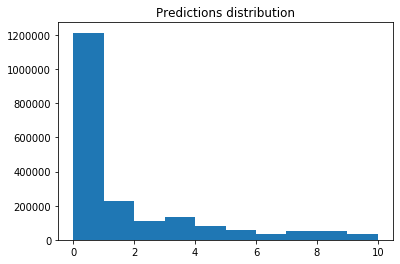

In [28]:
plt.hist(test_preds);
plt.title('Predictions distribution')

In [29]:
submission_df['open_channels'] = test_preds
submission_df.to_csv('submission.csv', index=False, float_format='%.4f')